In [1]:
# Experimental classifier that uses a CNN architecture and softmax activation in the last layer

import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import sklearn.metrics as skm
import os
from sklearn.model_selection import train_test_split


In [2]:
# Load the datasets

data_path = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/output/psf_dataset/'
train_dataset = np.load(data_path + 'train_12000_stars_id_002_8bins.npy', allow_pickle=True)[()]
test_dataset = np.load(data_path + 'test_1000_stars_id_002_8bins.npy', allow_pickle=True)[()]


In [78]:
def calculate_success_rate(confusion_matrix):
    """ Metric that contemplates success as the true spectral class with a tolerance of one adjacent class
    """
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

class TrainingCompletionCallback(tf.keras.callbacks.Callback):
    """ Callback to display training information only at the end of the training of one network
    """
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]
        final_acc = self.model.history.history['categorical_accuracy'][-1]
        final_val_acc = self.model.history.history['val_categorical_accuracy'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)
        print("Final accuracy:", final_acc, "Final validation accuracy:", final_val_acc)

completion_callback = TrainingCompletionCallback()

initializer = tf.keras.initializers.GlorotNormal(seed = 25)

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

class CNN_model:
    """Wrapper class to train the network with a PCA dataset and a given architecture."""
    def __init__(self, X_train, Y_train, X_test, Y_test, architecture):
        """Receives the name of the dataset and the already created network and loads the needed variables."""
        
        train_size = len(X_train)

        only_train_stars = False
        if only_train_stars:
            train_stars = np.expand_dims(X_train, axis = 3)
            x_train, self.x_test, y_train, self.y_test = train_test_split(
                train_stars, Y_train, test_size = int(train_size/2.6), shuffle = False
            )
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
                x_train, y_train, test_size = int(train_size/2.6/2.6), shuffle = False
            )
        else:
            train_stars = np.expand_dims(X_train, axis = 3)
            self.x_test = np.expand_dims(X_test, axis = 3)
            self.y_test = Y_test
        
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
                train_stars, Y_train,test_size = int(train_size/2.6), shuffle = False
            )

        self.y_train_cat = tf.keras.utils.to_categorical(self.y_train,num_classes = 13)
        self.y_val_cat = tf.keras.utils.to_categorical(self.y_val,num_classes = 13)
        self.y_test_cat = tf.keras.utils.to_categorical(self.y_test,num_classes = 13)
        
        self.learning = []
        self.model = architecture
        
    
    def train_model(self, learning_rate, training_epochs, patience_epochs, reduce_lr=False, batch_size=32):

        self.model.compile(
            loss = 'categorical_crossentropy',
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate),
            metrics = 'categorical_accuracy'
        )
        callbacks = [completion_callback]
        if patience_epochs>0:
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)
            callbacks.append(early_stopping)
        if reduce_lr:
            lr_red = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
            callbacks.append(lr_red)
            
            
        learn = self.model.fit(self.x_train, self.y_train_cat, batch_size=batch_size, epochs= training_epochs, verbose = 0, 
                                        callbacks = callbacks, validation_data=(self.x_val,self.y_val_cat), shuffle=True) 

        self.learning.append(learn)

    def predict_test(self, verbose = True):
        """Makes predictions on the test data."""
        y_test_pred = self.model.predict(self.x_test)
        class_predictions = np.argmax(y_test_pred, axis = 1)

        self.f1_test = skm.f1_score(self.y_test, class_predictions, average = None)
        self.f1_mean_test = np.mean(self.f1_test[:13])
        self.confusion_matrix_test = tf.math.confusion_matrix(self.y_test, class_predictions)
        self.success_rate_test = calculate_success_rate(self.confusion_matrix_test)

        if(verbose):
            print("Prediction results for the test set")
            print('Average F1 score:', self.f1_mean_test)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_test)
            print('\nSuccess rate:', self.success_rate_test)


    def predict_val(self, verbose = True):
        """Makes predictions on the validation data."""
        y_val_pred = self.model.predict(self.x_val)
        class_predictions = np.argmax(y_val_pred, axis = 1)

        self.f1_val = skm.f1_score(self.y_val, class_predictions, average = None)
        self.f1_mean_val = np.mean(self.f1_val[:13])
        self.confusion_matrix_val = skm.confusion_matrix(self.y_val, class_predictions)
        self.success_rate_val = calculate_success_rate(self.confusion_matrix_val)

        if(verbose):
            print("Prediction results for the validation set")
            print('Average F1 score:', self.f1_mean_val)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_val)
            print('\nSuccess rate:', self.success_rate_val)

    def save_model(self, N_model = 1, dir=None, name=None):
        if dir is None:
            self.model.save(f"saved_models/{self.dataset_name}/my_model_{N_model}.h5")
        if name is None:
            self.model.save(dir+f"my_model_{N_model}.h5")
        else:
            self.model.save(dir+name+".h5")

    def load_model(self, N_model = 1):
        self.model = tf.keras.models.load_model(f"saved_models/{self.configuration['config_name']}/{self.dataset_name}/my_model_{N_model}.h5")
        

    def plot_training_evolution(self):
        """Plot the loss function and accuracy evolution."""

        loss_evolution = self.learning[-1].history["loss"]
        val_loss_evolution = self.learning[-1].history["val_loss"]
        acc_evolution = self.learning[-1].history['categorical_accuracy']
        val_acc_evolution = self.learning[-1].history['val_categorical_accuracy']

        plt.figure(figsize = (9,5))
        plt.subplot(121)
        plt.plot(loss_evolution,label = "Train set")
        plt.plot(val_loss_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Loss function value")
        plt.legend()
        plt.title("Loss function evolution")

        plt.subplot(122)
        # plt.plot(acc_evolution)
        plt.plot(acc_evolution,label = "Train set")
        plt.plot(val_acc_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Categorical accuracy evolution")

        print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])
        print("Training accuracy:", acc_evolution[-1], ", Validation accuracy:", val_acc_evolution[-1])

    def plot_cf_matrix(self):
        plt.figure(figsize= (12,10))
        heatmap = plt.imshow(self.confusion_matrix_test[:13,:], cmap='Blues')
        plt.xticks(np.arange(13), star_class_labels)
        plt.yticks(np.arange(13), star_class_labels)
        plt.colorbar(heatmap)
        plt.xlabel("Estimated spectral type")
        plt.ylabel("True spectral type")
        plt.show()

    def plot_metrics(self):
        plt.figure(figsize = (9,5))
        plt.bar(np.arange(13), height = self.f1_test[:13], tick_label = star_class_labels ,label = "F1 score")
        plt.axhline(self.f1_mean_test, color='red', linestyle='--', label = 'F1 score average')
        plt.axhline(self.success_rate_test, color='purple', label = 'Success rate')
        plt.xlabel("Spectral class")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

In [79]:

train_star_offset = 2000
x_train = train_dataset['noisy_stars'][train_star_offset:]
y_train = train_dataset['SED_ids'][train_star_offset:]
x_test = test_dataset['noisy_stars']
y_test = test_dataset['SED_ids']

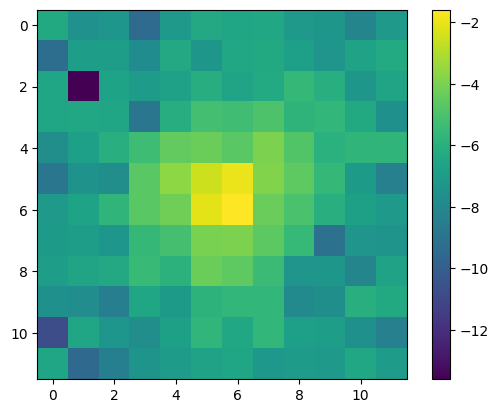

In [76]:
plt.imshow(np.log(np.abs(x_train[2][10:-10,10:-10])))
plt.colorbar()

Training completed. Number of epochs: 2000 , Final training loss: 1.3148680925369263 , Final validation loss: 1.4735150337219238
Final accuracy: 0.4543386399745941 Final validation accuracy: 0.3975558876991272
32/32 [==============================] - 0s 1ms/step
Prediction results for the test set
Average F1 score: 0.414020739166106

Confusion matrix:
tf.Tensor(
[[22 38  6  3  3  1  0  0  0  0  0  0  0]
 [27 36 12  5  2  1  1  0  0  0  0  0  0]
 [ 5 12 22 14 10  3  1  0  2  0  0  0  0]
 [ 3 11 14 21 13  7  1  0  1  0  0  0  0]
 [ 1  4 15 11 17 13  3  2  5  0  0  0  0]
 [ 0  1  4 11 18 24  7  2  4  0  2  0  0]
 [ 1  0  1  4 13 23 23  1 22  1  0  0  0]
 [ 0  1  1  3  3 10 18  7 26 12  3  0  0]
 [ 0  0  0  0  2 11  8  5 44 10  4  2  0]
 [ 0  0  0  1  1  4  7  7 13 20  8  0  0]
 [ 0  0  0  0  0  0  1  0  5 15 46 10  0]
 [ 0  0  0  0  0  0  0  0  1  0 17 60  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 84]], shape=(13, 13), dtype=int32)

Success rate: 0.751
Training loss: 1.3148680925369263 , V

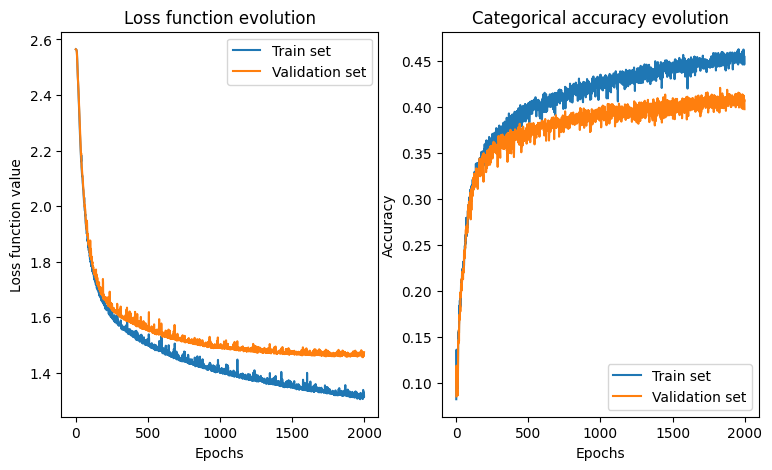

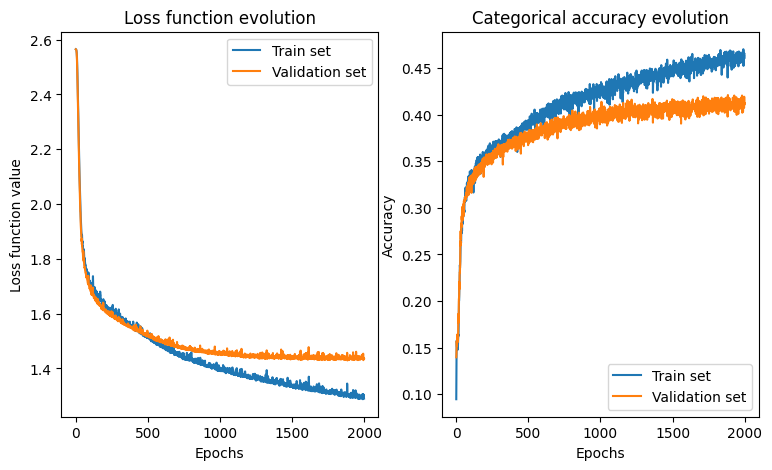

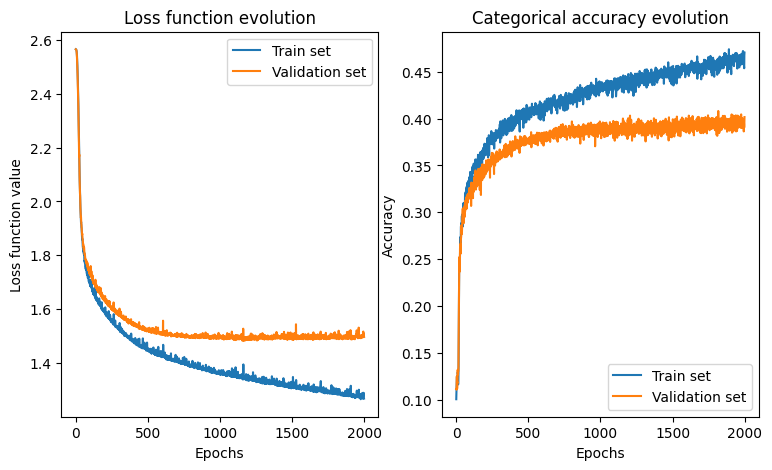

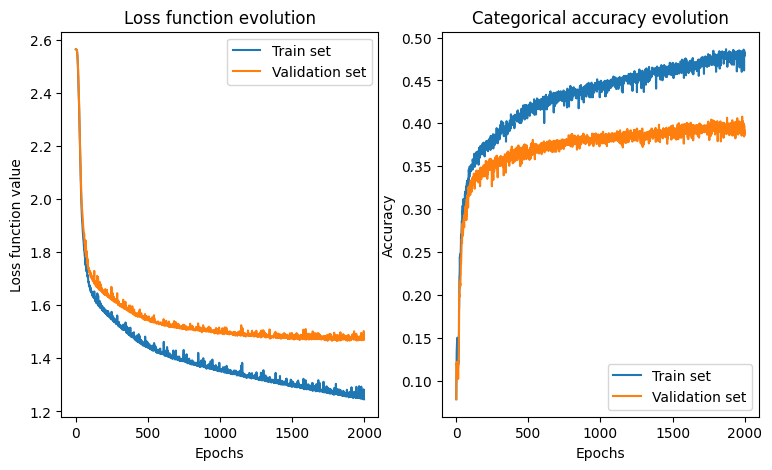

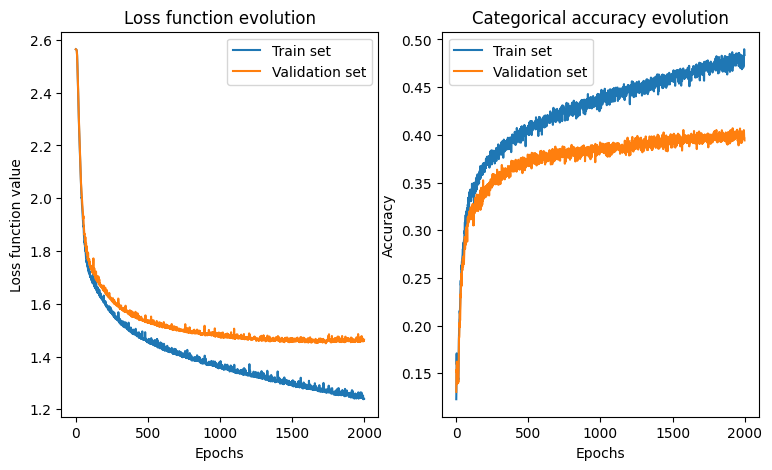

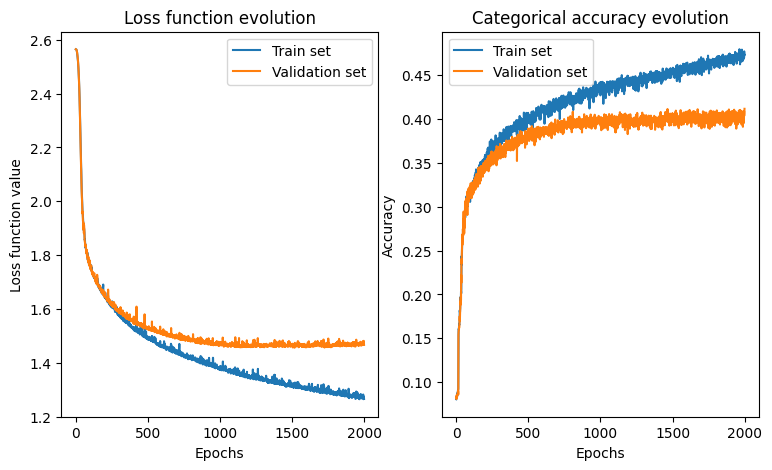

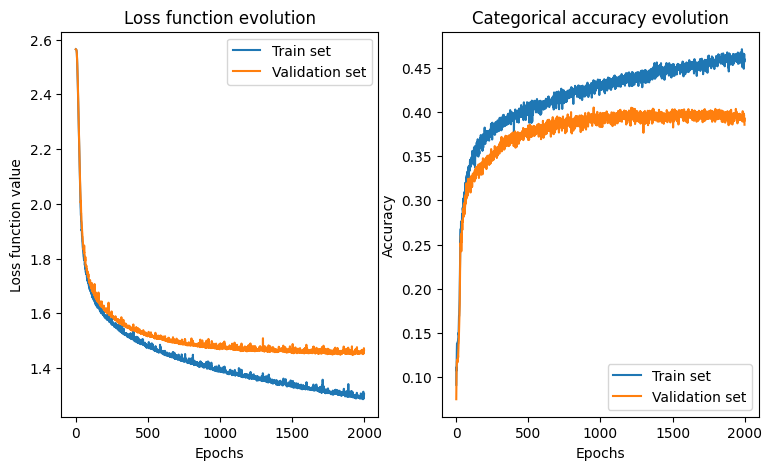

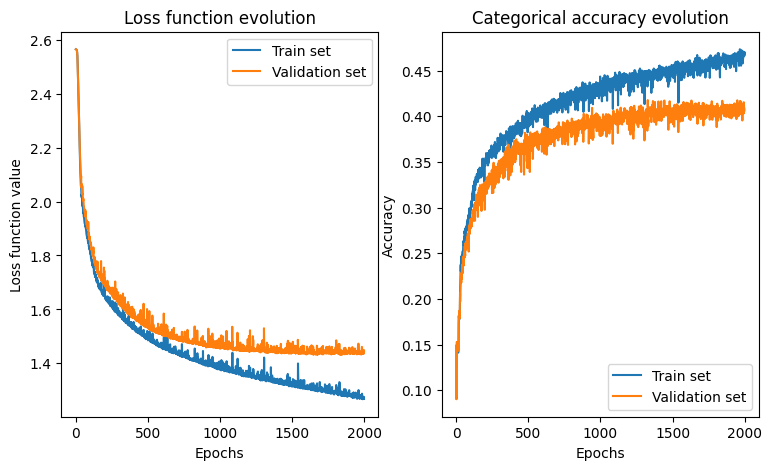

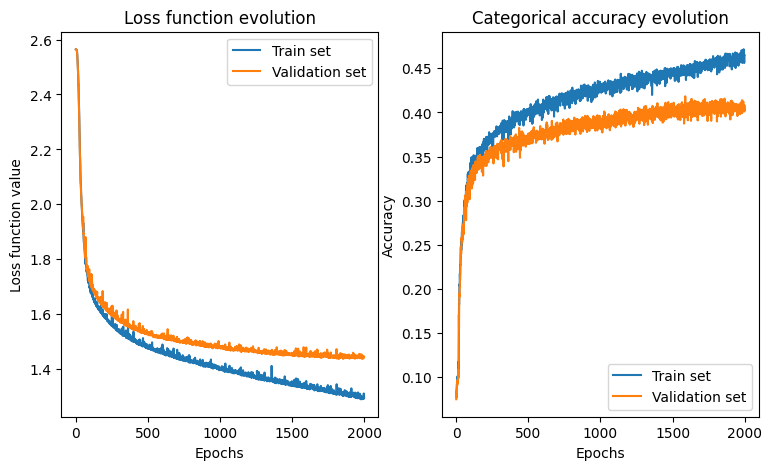

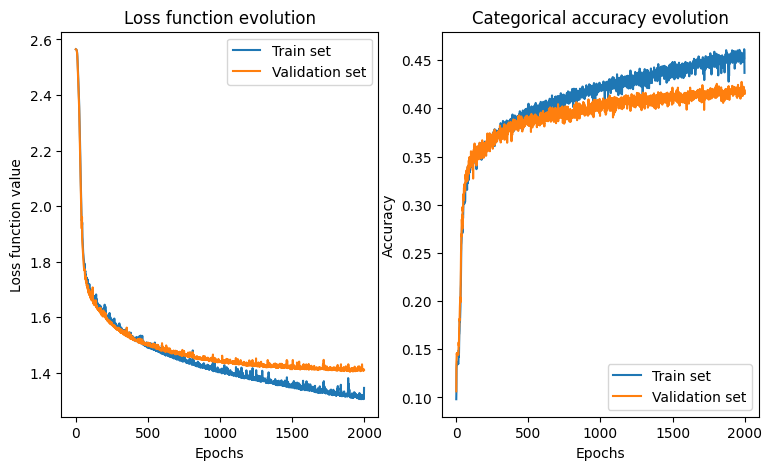

In [106]:
rand_runs = 10
cm_list = []

for run in range(rand_runs):
    architecture = tf.keras.Sequential([ 
        layers.Cropping2D(cropping=((10, 10), (10, 10)), input_shape = (32,32,1)),
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        # layers.MaxPooling2D((2,2)), #The original version has average pooling
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        # layers.MaxPooling2D((2,2)), #The original version has average pooling
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        # layers.MaxPooling2D((2,2)), #The original version has average pooling
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        # layers.MaxPooling2D((2,2)), #The original version has average pooling
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        layers.Conv2D(filters = 32, kernel_size = (2,2), activation = 'relu'),




        layers.Flatten(),
        # layers.Dropout(0.3),
        layers.Dense(32, activation = 'relu'),
        # layers.Dropout(0.3),
        layers.Dense(32, activation = 'relu'),
        # layers.Dropout(0.3),
        layers.Dense(13, activation = 'softmax'),
    ])

    # print architecture
    # architecture.summary()

    # Shuffle train and test datasets
    X_train_test = np.concatenate((x_train,x_test))
    Y_train_test = np.concatenate((y_train,y_test))
    randomize = np.arange(len(X_train_test))
    np.random.shuffle(randomize)
    X_train_test_rnd = X_train_test[randomize]
    Y_train_test_rnd = np.array(Y_train_test)[randomize]
    # Split the dataset into train and test
    x_train = X_train_test_rnd[:x_train.shape[0]]
    y_train = Y_train_test_rnd[:x_train.shape[0]]
    x_test = X_train_test_rnd[x_train.shape[0]:]
    y_test = Y_train_test_rnd[x_train.shape[0]:]

    # Data Normalization
    x_train_norm = (x_train-np.mean(x_train,axis=0))/np.max(np.mean(x_train, axis=0))
    x_test_norm = (x_test-np.mean(x_test,axis=0))/np.max(np.mean(x_test, axis=0))

    model3 = CNN_model(x_train_norm, y_train, x_test_norm, y_test, architecture)

    model3.train_model(training_epochs= 2000, learning_rate= 0.0001, patience_epochs= 0, batch_size=512)

    model3.predict_test()

    model3.plot_training_evolution()

    cm_list.append(model3.confusion_matrix_test)


np.save('CNN_pix_compression_classifier_cm_list.npy', cm_list)